## Lab 04 - Descarga de datos de Sentinel-2 por medio de SentinelHub

In [1]:
import os
from datetime import datetime
import json

from pathlib import Path

from sentinelhub import (
    SHConfig, BBox, Geometry, CRS, MimeType, DataCollection, 
    SentinelHubRequest, SentinelHubDownloadClient
)

from sentinelhub import bbox_to_dimensions
import matplotlib.pyplot as plt
import rasterio, numpy as np


# Librería utilizada para utilizar el ClientID / ClientKey de SentinelHub (API)
from dotenv import load_dotenv
load_dotenv()



c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab04-DS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

#### Verificación de .env para utilizar SentinelHub

In [2]:
config = SHConfig()
config.sh_client_id = os.getenv("SH_CLIENT_ID") or "CLIENT_ID"
config.sh_client_secret = os.getenv("SH_CLIENT_SECRET") or "CLIENT_SECRET"

if "CLIENT_ID" in config.sh_client_id:
    raise ValueError("Configura SH_CLIENT_ID y SH_CLIENT_SECRET (variables de entorno o aquí mismo).")


#### Conjunto de fechas recomendado a descargar (<=20% de nubosidad)

In [3]:
# Utilizar este array para descargar todos los datos de una sola vez
DATES=[
    "2025-02-07","2025-02-10","2025-02-25","2025-02-27","2025-03-02","2025-03-04","2025-03-07",
    "2025-03-09","2025-03-12","2025-03-14","2025-03-19","2025-03-22","2025-03-24","2025-03-26",
    "2025-04-03","2025-04-11","2025-04-13","2025-04-15","2025-04-16","2025-04-18","2025-04-28",
    "2025-05-03","2025-05-13","2025-05-28","2025-07-10","2025-07-17","2025-07-20","2025-07-24",
    "2025-08-01"
]


# Renombrar cada uno de estos a DATES cuando se quiera procesar por batches pequeños
DATES1 = [
    "2025-02-07","2025-02-10","2025-02-25","2025-02-27","2025-03-02","2025-03-04","2025-03-07"
]

DATES2 = [
    "2025-03-09","2025-03-12","2025-03-14","2025-03-19","2025-03-22","2025-03-24","2025-03-26"
]

DATES3 = [
    "2025-04-03","2025-04-11","2025-04-13","2025-04-15","2025-04-16","2025-04-18","2025-04-28"
]

DATES4 = [
    "2025-05-03","2025-05-13","2025-05-28","2025-07-10","2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]

#### Coordenadas de las AoI

In [4]:
LAKES_BBOX = {
    "atitlan":   (-91.326256, 14.5948,   -91.07151, 14.750979),
    "amatitlan": (-90.638065, 14.412347, -90.512924, 14.493799),
}

#### Definir aquí la ruta del GeoJSON si se proporciona (en nuestro caso usamos las coordenadas brindadas por el catedrático)

In [5]:
GEOJSON_PATH = None

#### Utilizar la colección del Sentinel-2 L2A

In [6]:
COLLECTION = DataCollection.SENTINEL2_L2A

#### Carpeta output de las imagenes de los lagos

In [7]:
OUT_DIR = Path("descargas_sentinelhub"); OUT_DIR.mkdir(parents=True, exist_ok=True)

#### Establecimiento de las bandas en Float32 (B02-B12) y las bandas en U8 (SCL, dataMask)

In [8]:
EVAL_BANDS_F32 = """//VERSION=3
function setup(){return{input:[{bands:["B02","B03","B04","B05","B07","B08","B8A","B11","B12"],units:"REFLECTANCE",resampling:"BILINEAR"}],
                         output:{bands:9,sampleType:SampleType.FLOAT32}}}
function evaluatePixel(s){return[s.B02,s.B03,s.B04,s.B05,s.B07,s.B08,s.B8A,s.B11,s.B12]}"""

EVAL_MASK_U8 = """//VERSION=3
function setup(){return{input:[{bands:["SCL","dataMask"]}],
                         output:{bands:2,sampleType:SampleType.UINT8}}}
function evaluatePixel(s){return[s.SCL,s.dataMask]}"""

#### Funciones para realizar ajustes de fechas y cargar el archivo GeoJSON (si existiera)

In [9]:
def day_timerange(date_str):
    return (f"{date_str}T00:00:00Z", f"{date_str}T23:59:59Z")

def load_lakes_from_geojson(geojson_path):
    with open(geojson_path, "r", encoding="utf-8") as f:
        fc = json.load(f)
    if fc.get("type") != "FeatureCollection":
        raise ValueError("El GeoJSON debe ser un FeatureCollection.")
    lakes = {}
    for i, feat in enumerate(fc.get("features", [])):
        geom = feat.get("geometry")
        if not geom: 
            continue
        props = feat.get("properties") or {}
        name = str(props.get("name") or props.get("title") or props.get("id") or f"feature_{i}")
        lakes[name] = Geometry(geom, crs=CRS.WGS84)
    if not lakes:
        raise ValueError("No se encontraron features con geometría.")
    return lakes

def sanitize(name: str) -> str:
    return "".join(ch if ch.isalnum() or ch in ("-", "_") else "_" for ch in name.lower())

#### Cargar con coordenadas directas o GeoJSON (si existiera)

In [10]:
if GEOJSON_PATH:
    LAKES_GEOM = load_lakes_from_geojson(GEOJSON_PATH)  # dict: name -> Geometry
else:
    LAKES_GEOM = {name: BBox(bbox=coords, crs=CRS.WGS84) for name, coords in LAKES_BBOX.items()}


#### Definición de resolución máxima

In [11]:
MAX_PX = 2500          # límite de la Processing API
RESOLUTION_M = 10      # objetivo de GSD, si hace overflow, se ajusta automáticamente

def compute_size_for_area(area, target_res_m=RESOLUTION_M, max_px=MAX_PX):
    """
    Devuelve (width_px, height_px) calculados a partir del bbox del área y una resolución en metros,
    ajustando si fuese necesario para no superar max_px.
    """
    # Obtenemos un BBox del área (si ya es BBox, lo usamos tal cual)
    if isinstance(area, BBox):
        bbox = area
    else:
        try:
            bbox = area.bbox
        except Exception:
            raise ValueError("No se pudo obtener el bbox de la geometría.")

    # Calcula dimensiones aproximadas para la resolución solicitada
    w_px, h_px = bbox_to_dimensions(bbox, target_res_m)

    # Si excede el límite, escalamos
    scale = max(w_px / max_px, h_px / max_px, 1.0)
    w_px = int(max(1, round(w_px / scale)))
    h_px = int(max(1, round(h_px / scale)))
    print(f"  -> tamaño: {w_px}x{h_px}px | res. efectiva ~{target_res_m / scale:.1f} m/px")
    return (w_px, h_px)

#### Flujo principal de descarga y exportación de archivos `.tiff`

In [12]:
client = SentinelHubDownloadClient(config=config)

def build_request(area, date_str, evalscript, out_folder=None):
    time_from, time_to = day_timerange(date_str)
    common_kwargs = dict(
        evalscript=evalscript,
        input_data=[SentinelHubRequest.input_data(
            data_collection=COLLECTION,
            time_interval=(time_from, time_to),
            mosaicking_order="leastCC"
            
        )],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        config=config
    )
    if out_folder is not None:
        common_kwargs["data_folder"] = str(out_folder)

    w_px, h_px = compute_size_for_area(area, RESOLUTION_M, MAX_PX)

    if isinstance(area, BBox):
        return SentinelHubRequest(bbox=area, size=(w_px, h_px), **common_kwargs)
    else:
        return SentinelHubRequest(geometry=area, size=(w_px, h_px), **common_kwargs)

OUT_EXT = ".tiff"

def _list_geotiffs(root: Path):
    patterns = ("*.tif", "*.tiff")
    files = []
    for pat in patterns:
        files.extend(root.rglob(pat))
    # ordena por fecha de modificación, más reciente primero
    return sorted(files, key=lambda p: p.stat().st_mtime, reverse=True)

def download_one(area_name, area, date_str, evalscript, suffix):
    out_folder = OUT_DIR / sanitize(area_name); out_folder.mkdir(parents=True, exist_ok=True)
    out_path = out_folder / f"{sanitize(area_name)}__{date_str}{suffix}"
    if out_path.exists(): 
        print(f"[skip] {out_path.name}"); 
        return
    req = build_request(area, date_str, evalscript=evalscript, out_folder=out_folder)
    before = set(_list_geotiffs(out_folder))
    req.get_data(save_data=True)
    after = _list_geotiffs(out_folder)
    new_tif = [p for p in after if p not in before][0] if [p for p in after if p not in before] else after[0]
    new_tif.replace(out_path)
    print(f"[ok] {area_name} {date_str} -> {out_path}")

        
# Valida formato de fechas
for d in DATES:
    datetime.strptime(d, "%Y-%m-%d")

# Lanza descargas
for lake_name, area in LAKES_GEOM.items():
    print(f"\n=== Lago: {lake_name} ===")
    for d in DATES:
        download_one(lake_name, area, d, EVAL_BANDS_F32, suffix=".bands.tiff")
        download_one(lake_name, area, d, EVAL_MASK_U8,  suffix=".mask.tiff")


=== Lago: atitlan ===
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-07 -> descargas_sentinelhub\atitlan\atitlan__2025-02-07.bands.tiff
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-07 -> descargas_sentinelhub\atitlan\atitlan__2025-02-07.mask.tiff
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-10 -> descargas_sentinelhub\atitlan\atitlan__2025-02-10.bands.tiff
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-10 -> descargas_sentinelhub\atitlan\atitlan__2025-02-10.mask.tiff
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-25 -> descargas_sentinelhub\atitlan\atitlan__2025-02-25.bands.tiff
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-25 -> descargas_sentinelhub\atitlan\atitlan__2025-02-25.mask.tiff
  -> tamaño: 2500x1603px | res. efectiva ~9.2 m/px
[ok] atitlan 2025-02-27 -> descargas_sentinelhub\atitlan\atitlan__2025-02-27.bands.tiff
  -> ta

### Verificación de integridad y usabilidad de los `.tiff`

#### Carga de bandas

In [14]:
bands_path = "descargas_sentinelhub/atitlan/atitlan__2025-02-07.bands.tiff"
mask_path  = "descargas_sentinelhub/atitlan/atitlan__2025-02-07.mask.tiff"


#"B02","B03","B04","B05","B07","B08","B8A","B11","B12"
b02,b03,b04,b05,b07,b08,b8a,b11,b12 = rasterio.open(bands_path).read().astype("float32")   # reflectancia [0..1]
scl,dm          = rasterio.open(mask_path).read().astype("uint8")
valid = (dm > 0) & (~np.isin(scl, [3,8,9,10,11]))
ndvi = (b08-b04)/(b08+b04+1e-6)

#### Gráficas de test para true color, B02, B03, B04, B08, SCL y NDVI

Band count: 9 | dtypes: ('float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32')


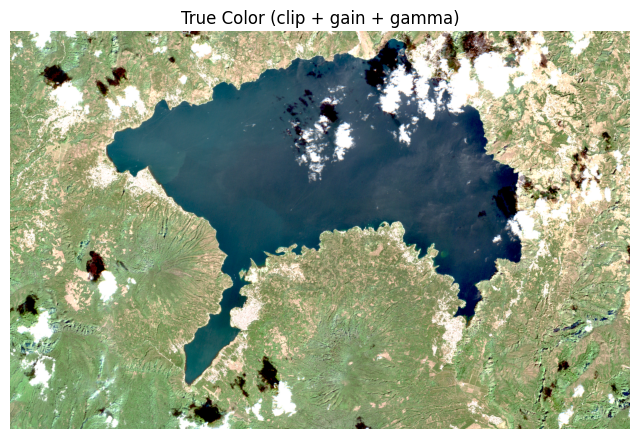

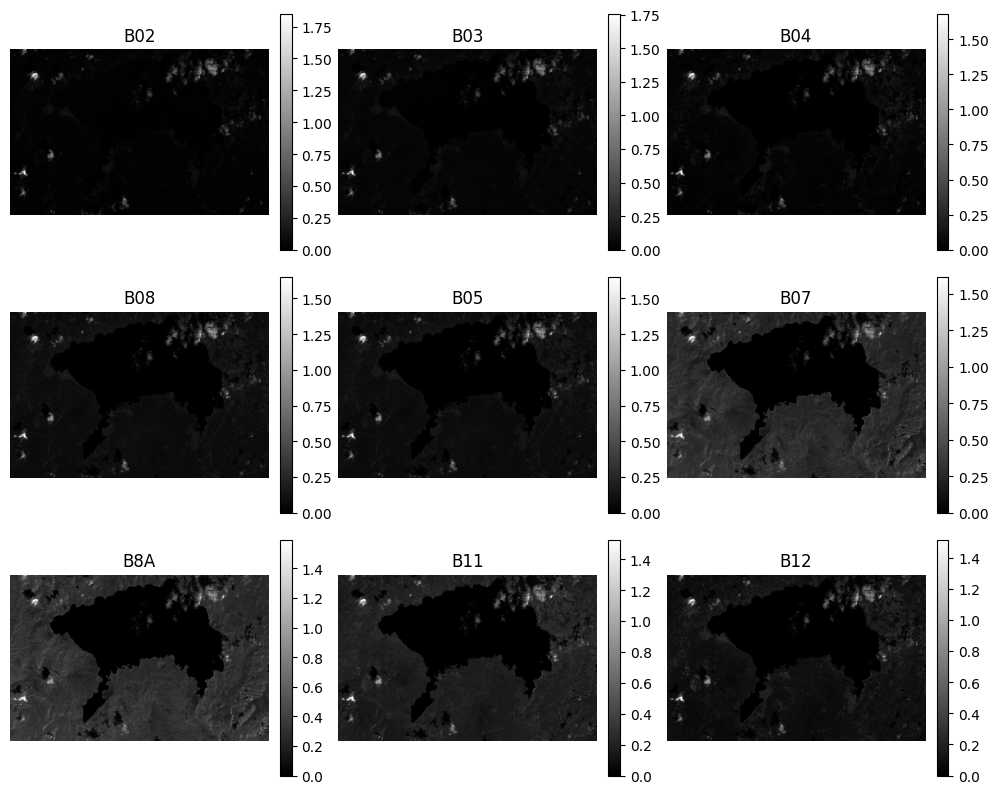

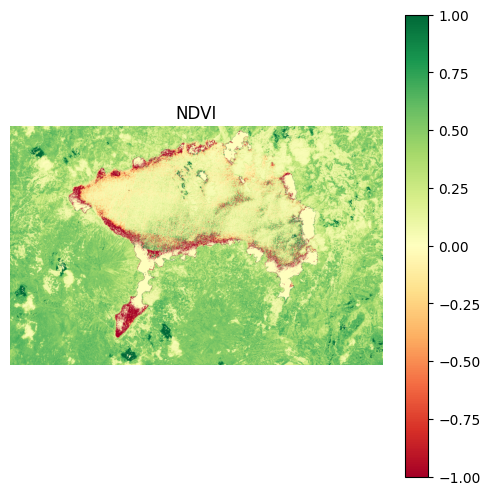

In [18]:
ruta = "descargas_sentinelhub/atitlan/atitlan__2025-02-07.bands.tiff"

SCL_BAD = {3, 8, 9, 10, 11}

def auto_to_reflectance(arr):
    """Convierte a reflectancia [0..1] según dtype/rango si viene en enteros."""
    if np.issubdtype(arr.dtype, np.floating):
        return arr.astype("float32")
    p99 = np.percentile(arr, 99)
    if p99 <= 1.2:   scale = 1.0
    elif p99 <= 255: scale = 255.0
    elif p99 <= 4095: scale = 4095.0
    elif p99 <= 11000: scale = 10000.0
    else:            scale = 65535.0
    return arr.astype("float32") / scale

def per_channel_stretch(rgb, mask=None, pmin=2, pmax=98, gain=2.5, gamma=2.2):
    out = rgb.copy().astype("float32")
    if mask is not None:
        out = np.ma.array(out, mask=np.dstack([~mask]*3))
    for i in range(3):
        lo, hi = np.nanpercentile(out[..., i], [pmin, pmax])
        out[..., i] = np.clip((out[..., i] - lo) / max(hi - lo, 1e-6), 0, 1)
    out = np.clip(out * gain, 0, 1)
    out = np.power(out, 1/gamma)
    return out

with rasterio.open(ruta) as src:
    data = src.read()
    print("Band count:", src.count, "| dtypes:", src.dtypes)
    if src.count >= 11:
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 , scl, dm = data[:11]
        has_mask = True
    else:
        b02, b03, b04, b08 = data[:4]
        scl = dm = None
        has_mask = False

# Máscara de válidos
if has_mask:
    valid = (dm > (0.5 if np.issubdtype(dm.dtype, np.floating) else 0)) & (~np.isin(scl.astype(int), list(SCL_BAD)))
else:
    valid = np.ones_like(b02, dtype=bool)

# Reflectancia
b02r = np.ma.array(auto_to_reflectance(b02), mask=~valid)
b03r = np.ma.array(auto_to_reflectance(b03), mask=~valid)
b04r = np.ma.array(auto_to_reflectance(b04), mask=~valid)
b08r = np.ma.array(auto_to_reflectance(b08), mask=~valid)
b05r = np.ma.array(auto_to_reflectance(b05), mask=~valid)
b07r = np.ma.array(auto_to_reflectance(b07), mask=~valid)
b8ar = np.ma.array(auto_to_reflectance(b8a), mask=~valid)
b11r = np.ma.array(auto_to_reflectance(b11), mask=~valid)
b12r = np.ma.array(auto_to_reflectance(b12), mask=~valid)

# ---- TRUE COLOR ----
rgb = np.dstack([b04r, b03r, b02r])
rgb_view = per_channel_stretch(rgb, mask=valid, pmin=2, pmax=98, gain=2.5, gamma=2.2)
plt.figure(figsize=(8,6)); plt.imshow(rgb_view); plt.title("True Color (clip + gain + gamma)"); plt.axis("off"); plt.show()

# ---- BANDAS INDIVIDUALES ----
fig, axs = plt.subplots(3, 3, figsize=(10,8))
for ax, arr, name in zip(axs.ravel(), [b02r,b03r,b04r,b08r,b05r,b07r,b8ar,b11r,b12r], ["B02","B03","B04","B08","B05","B07","B8A","B11","B12"]):
    im = ax.imshow(arr, cmap="gray"); ax.set_title(name); ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# ---- NDVI ----
ndvi = (b08r - b04r) / (b08r + b04r + 1e-6)
plt.figure(figsize=(6,6))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("NDVI"); plt.colorbar(); plt.axis("off"); plt.show()
